## **Model Inference**

### **Set Up**

In [1]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import Counter
import random

from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import kagglehub
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Download latest version of data
path = kagglehub.dataset_download("mostafaabla/garbage-classification")
print("Path to dataset files:", path)

Path to dataset files: /Users/youhorng/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1


In [3]:
# Check the directories inside the path
print(os.listdir(path))

['garbage_classification']


In [4]:
# Define the dataset directory
DATA_DIR = path + "/garbage_classification"

# Setup up configuration for global constant variables
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

In [5]:
# Define data path
data_path = Path(DATA_DIR)

# Sort class names from the main directory
class_names = sorted([d.name for d in data_path.iterdir() if d.is_dir()])

# Create class index
class_to_idx = {name: i for i, name in enumerate(class_names)}
num_classes = len(class_names)

print("Classes:", class_names)
print("Num classes:", num_classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Num classes: 12


In [6]:
# Define path and labels
paths = []
labels = []

for class_name in class_names:
    class_dir = data_path / class_name

    for img_path in class_dir.glob("*.*"):
        paths.append(str(img_path))
        labels.append(class_to_idx[class_name])

paths = np.array(paths)
labels = np.array(labels)

print("Total images: ", len(paths))

Total images:  15515


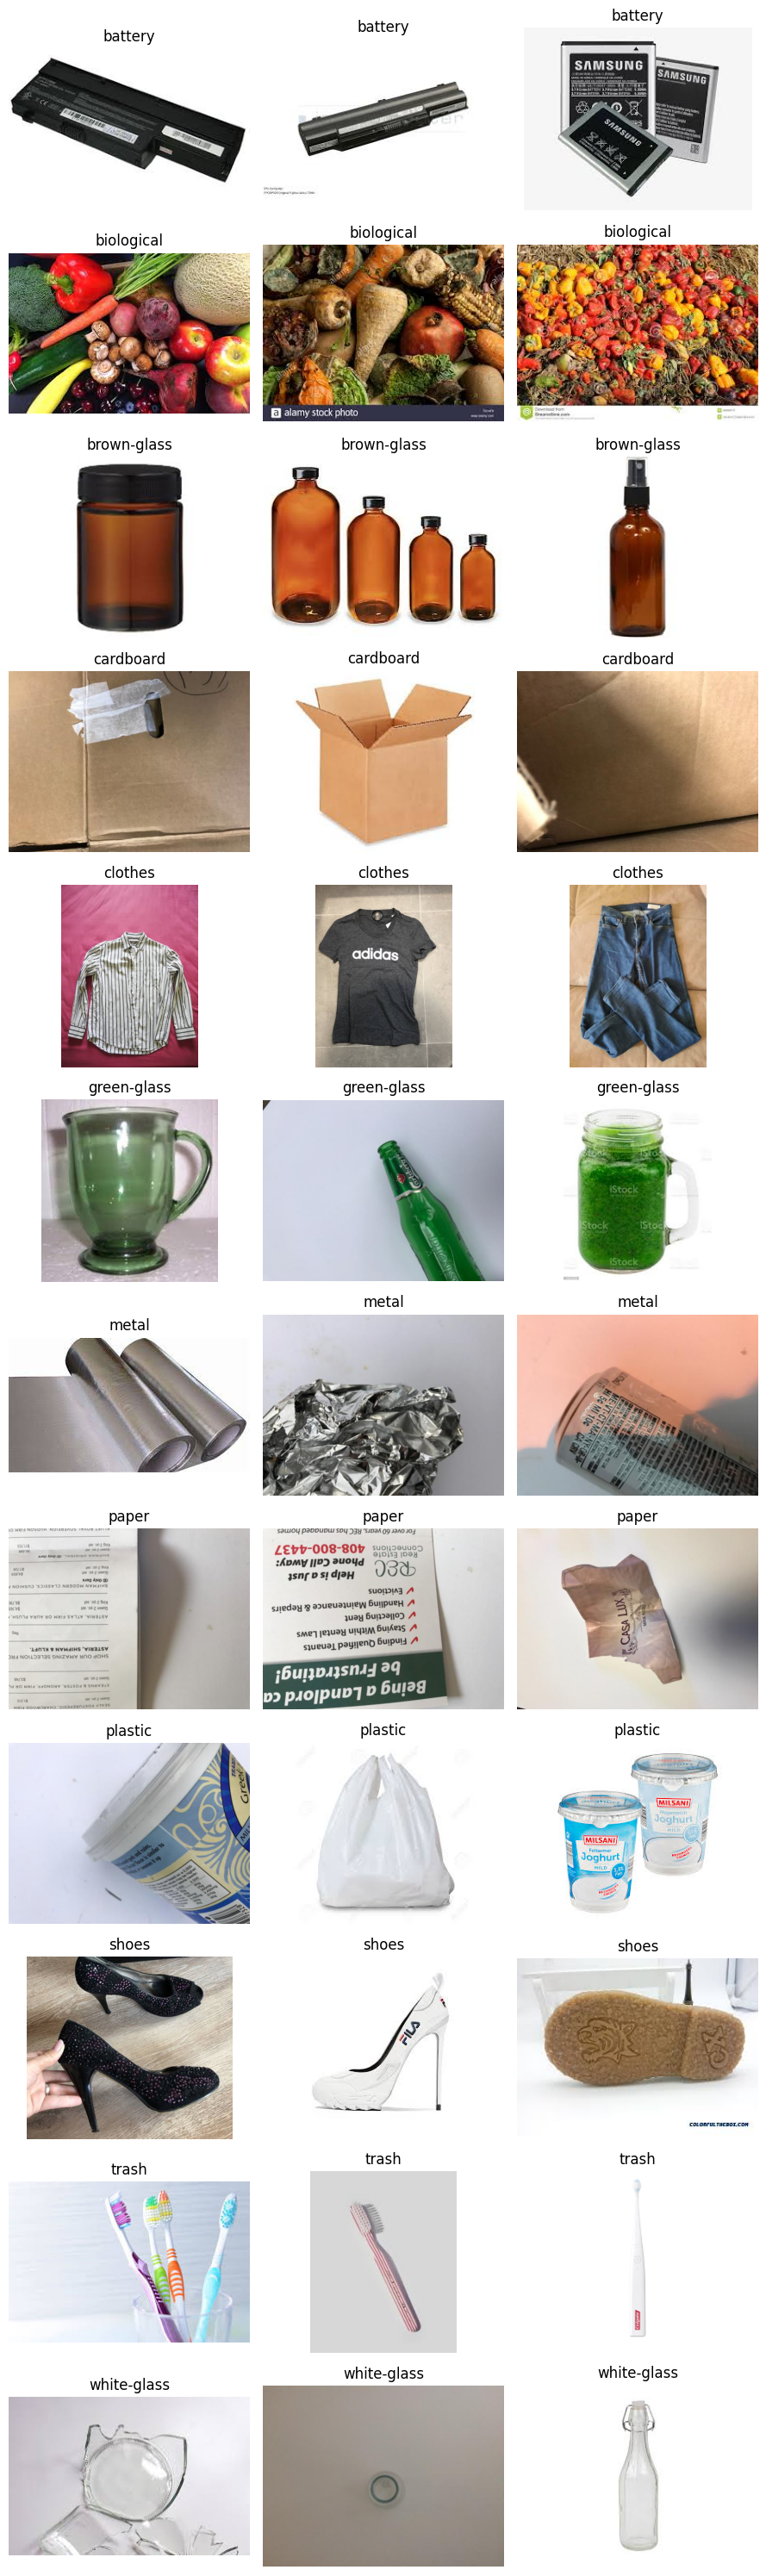

In [7]:
# Visualize the classes images
n_samples_per_class = 3

n_cols = n_samples_per_class
n_rows = num_classes

plt.figure(figsize=(3 * n_cols, 2.5 * n_rows))

for row, cname in enumerate(class_names):
    # Get indices for this class
    class_idx = class_to_idx[cname]
    indices = [i for i, lbl in enumerate(labels) if lbl == class_idx]
    # Pick random samples
    sample_indices = random.sample(indices, min(n_samples_per_class, len(indices)))

    for col, idx in enumerate(sample_indices):
        img_path = paths[idx]
        img = Image.open(img_path).convert("RGB")

        ax = plt.subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(img)
        ax.set_title(cname)
        ax.axis("off")
        if col == 0:
            ax.set_ylabel(cname, rotation=0, labelpad=40, fontsize=10, va="center")

plt.tight_layout()
plt.show()

### **Data Preparation**

In [8]:
# Split the dataset into train/val/test - 70/15/15
paths_train, paths_temp, labels_train, labels_temp = train_test_split(
    paths,
    labels,
    test_size=0.3,
    stratify=labels,
    random_state=SEED
)

# Split on temp (val/test)
paths_val, paths_test, labels_val, labels_test = train_test_split(
    paths_temp,
    labels_temp,
    test_size=0.5,
    stratify=labels_temp,
    random_state=SEED
)

print("Train:", len(paths_train))
print("Val:", len(paths_val))
print("Test:", len(paths_test))

Train: 10860
Val: 2327
Test: 2328


In [ ]:
# Set autotune for optimal performance setting for data pipelines
AUTOTUNE = tf.data.AUTOTUNE

# Define a function to decode and resize images
def decode_and_resize(path, label):

    # Read file path
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32)

    return img, label


# Define a function to make the dataset
def make_dataset(paths, labels, shuffle=False):

    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)

    # Decode and resize the image
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return ds



In [10]:
# Create train, test, and val dataset
train_ds = make_dataset(paths_train, labels_train, shuffle=True)
val_ds   = make_dataset(paths_val,   labels_val,   shuffle=False)
test_ds  = make_dataset(paths_test,  labels_test,  shuffle=False)

### **Inference**

In [12]:
# Load the tflite model
PROJECT_ROOT = Path("/Users/youhorng/Desktop/projects/trash-sorting-cnn")
TFLITE_MODEL_PATH = PROJECT_ROOT / "checkpoint/convnext_ft40_lr1e-04.tflite"

# Initialize the interpreter
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = input_details[0]['index']
output_index = output_details[0]['index']

print("Input:", input_details)
print("Output:", output_details)

Input: [{'name': 'serving_default_input_layer_5:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output: [{'name': 'StatefulPartitionedCall_1:0', 'index': 688, 'shape': array([ 1, 12], dtype=int32), 'shape_signature': array([-1, 12], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [25]:
# Define a function to predict the image
def predict_batch_tflite(images):
    images = images.numpy().astype(np.float32)

    # Resize input tensor if batch size changes
    current_shape = interpreter.get_input_details()[0]['shape']
    if tuple(current_shape) != images.shape:
        interpreter.resize_tensor_input(input_index, images.shape)
        interpreter.allocate_tensors()

    interpreter.set_tensor(input_index, images)
    interpreter.invoke()

    preds = interpreter.get_tensor(output_index)
    return preds

In [26]:
# Loop over the testing set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = predict_batch_tflite(images)
    pred_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

2025-11-24 14:55:31.569886: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Evaluate the model
acc = accuracy_score(y_true, y_pred)
print(f"TFLite Test Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


TFLite Test Accuracy: 0.9888

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       1.00      0.99      0.99       148
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00       134
           4       1.00      0.99      0.99       799
           5       0.98      0.99      0.98        94
           6       0.97      0.97      0.97       115
           7       0.99      0.99      0.99       158
           8       0.98      0.98      0.98       130
           9       0.98      0.99      0.98       297
          10       0.99      0.98      0.99       104
          11       0.96      0.97      0.97       116

    accuracy                           0.99      2328
   macro avg       0.99      0.99      0.99      2328
weighted avg       0.99      0.99      0.99      2328


Confusion Matrix:
[[142   0   0   0   0   0   0   0   0   0   0   0]
 [  0 146 

In [13]:
# Define a function to predict new test sample
def show_prediction_sample_tflite(idx, interpreter, paths, labels, class_names):
    img_path = paths[idx]
    true_label = labels[idx]

    # Load and resize image (same as test ds)
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)  

    # Save original for plotting
    img_display = img_array.astype("uint8")

    # Add batch dimension and keep as float32 in [0, 255]
    img_batch = np.expand_dims(img_array, axis=0).astype("float32")

    # Resize input tensor if needed 
    if tuple(interpreter.get_input_details()[0]['shape']) != img_batch.shape:
        interpreter.resize_tensor_input(input_index, img_batch.shape)
        interpreter.allocate_tensors()

    interpreter.set_tensor(input_index, img_batch)
    interpreter.invoke()
    preds = interpreter.get_tensor(output_index)[0] 

    # Predicted class
    pred_class_idx = int(np.argmax(preds))
    pred_class_name = class_names[pred_class_idx]
    confidence = float(np.max(preds))

    # Plot the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img_display.astype("uint8"))
    plt.axis("off")

    plt.title(
        f"True: {class_names[true_label]}\nPredicted: {pred_class_name}\nConf: {confidence:.2f}",
        fontsize=12,
        color="green" if pred_class_idx == true_label else "red",
    )
    plt.show()

    return pred_class_name, confidence


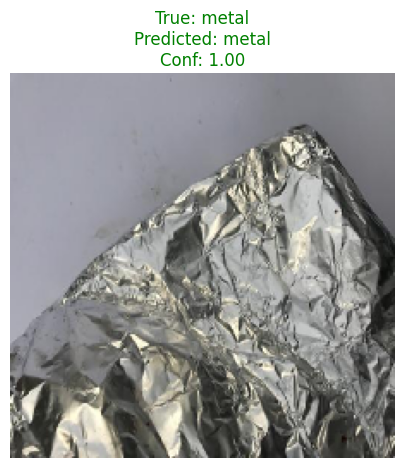

('metal', 0.9997711777687073)

In [14]:
# Predict the image
i = random.randint(0, len(paths_test)-1)
show_prediction_sample_tflite(i, interpreter, paths_test, labels_test, class_names)

/Users/youhorng/Desktop/projects/trash-sorting-cnn/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


FileUpload(value=(), accept='image/*', description='Upload')

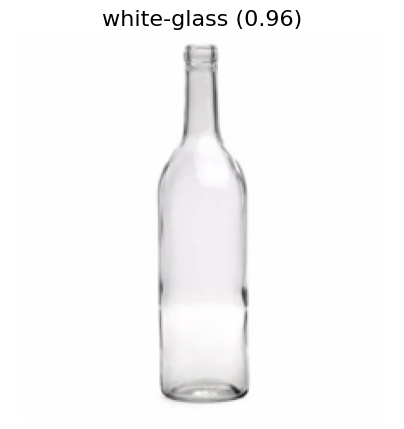

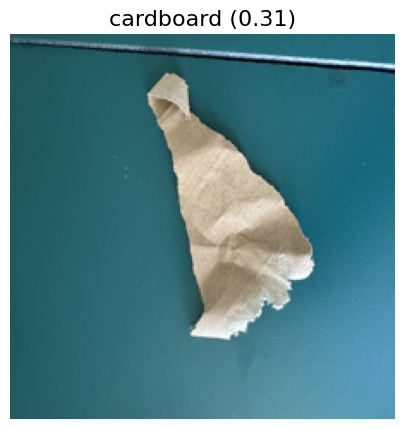

In [ ]:
import io
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

IMG_SIZE = 224

# ----- Load TFLite model -----
TFLITE_MODEL_PATH = "/Users/youhorng/Desktop/projects/trash-sorting-cnn/checkpoint/convnext_ft40_lr1e-04.tflite"  # adjust if needed

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.resize_tensor_input(0, [1, IMG_SIZE, IMG_SIZE, 3])
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_idx = input_details[0]["index"]
output_idx = output_details[0]["index"]

# ----- Correct class names from training -----
class_names = [
    'battery',
    'biological',
    'brown-glass',
    'cardboard',
    'clothes',
    'green-glass',
    'metal',
    'paper',
    'plastic',
    'shoes',
    'trash',
    'white-glass',
]

def preprocess_for_tflite(pil_img):
    img = pil_img.convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype("float32")   # [0, 255]
    arr = np.expand_dims(arr, axis=0)       # (1, 224, 224, 3)
    return arr, img

upload_btn = widgets.FileUpload(accept="image/*", multiple=False)

def on_upload(change):
    if len(upload_btn.value) == 0:
        return

    file_info = upload_btn.value[0]
    img_bytes = file_info["content"]

    pil_img = Image.open(io.BytesIO(img_bytes))
    arr, display_img = preprocess_for_tflite(pil_img)

    interpreter.set_tensor(input_idx, arr)
    interpreter.invoke()
    preds = interpreter.get_tensor(output_idx)[0]

    idx = int(np.argmax(preds))
    label = class_names[idx]
    confidence = float(preds[idx])

    plt.figure(figsize=(5, 5))
    plt.imshow(display_img)
    plt.axis("off")
    plt.title(f"{label} ({confidence:.2f})", fontsize=16)
    plt.show()

    print("Predicted index:", idx)
    print("Predicted label:", label)
    print("Confidence:", round(confidence, 3))

upload_btn.observe(on_upload, names="value")
display(upload_btn)
